In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

I decided to look at some data about outbound sales calls by a bank for a new product of theirs. 

[TODO: more details about the bank here]

My goal will be to build a Machine Learning model to predict what types of customers are most likely to buy the product because of a telemarketing call. Such a model could help the bank spend its sales and marketing budget more effectively. It could also be used to predict the success of using telemarketing to promote new products.

I obtained this data from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

This data was used in the following research papter:

```[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014```

The paper can be read online with a CU Boulder account here: https://www.sciencedirect.com/science/article/pii/S016792361400061X#t0010

Let's import, clean up, and analyze the data to determine which Machine Learning algorithms are suitable for classifying this data.

In [3]:
## file obtained from https://archive.ics.uci.edu/ml/machine-learning-databases/00222/

bank_data = pd.read_csv("bank-additional-full.csv", delimiter=";")

bank_data.sample()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
28268,55,admin.,divorced,university.degree,no,yes,no,cellular,apr,wed,...,1,999,1,failure,-1.8,93.075,-47.1,1.445,5099.1,no


In [4]:
for col in bank_data.columns:
    if bank_data[col].isnull().any():
        print(f"Nulls in {bank_data[col]}")

Based on this, the data looks pretty clean. We have some unknown values, but no `na` values to contend with. Let's start looking at individual columns. For starters, `age` seems pretty reasonable. The youngest age is 17 and the max is 98.

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64


<AxesSubplot:>

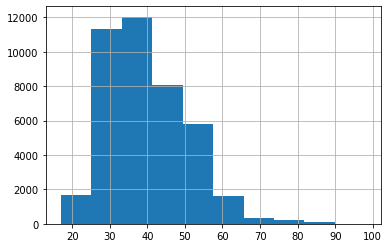

In [5]:
print(bank_data.age.describe())

bank_data.age.hist()

Next, let's check the categorical variables, such as `job`, `marital`, `education`, `default`, `housing`, `loan`, and `contact`. The simplest way to visualize these is just using value_counts() on the columns that do not have a numeric type.

In [6]:
for col in bank_data.columns:
    if bank_data[col].dtype == 'object':
        print(bank_data[col].value_counts())
        print("\n")

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64


married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64


no         32588
unknown     8597
yes            3
Name: default, dtype: int64


yes        21576
no         18622
unknown      990
Name: housing, dtype: int64


no         33950
yes         6248
unknown      990
Name: loan, dtype: int64


cellular     26144
telephone    15044
Name: contact, dtype: int64


may    13769
jul     717

Many of the categorical variables have 'unknown' values: `job`, `marital`, `education`, `default`, `housing`, `loan`. (for reference, `default` is whether the customer is in default on any loans. `housing` is whether the customer has a housing loan. `loan` is whether the customer has a non-housing loan.)

While unknown values are not ideal, I don't believe it makes sense to throw out these values. If we find that customers with `unknown` values are less likely to buy the product, that tells us something too: that the business should stop trying to market to customers that they don't have enough demographic information about. In other words, `unknown` conveys less information than the other categorical values, but not zero information.

The rest of the categorical variables look good: `month`, `day_of_week`, and `poutcome`. (`month` and `day_of_week` indicate when the customer was contacted. `poutcome` is whether previous marketing campaigns to this person were successful.)

`y` is whether the sales attempt was successful or not. About 90% of sales calls are unsuccessful. That's a pretty big class imbalance, which means we need to be careful with how we select and score our model, because a model that always predicts `no`, regardless of the feature data, would be accurate 89% of the time:

In [7]:
print(100 * sum(bank_data.y == "no") / len(bank_data.y))

88.73458288821988


For instance, when using `sklearn.svm.SVC` to classify this data, we will want to use the argument `class_weight='balanced'`. And we will use sklearn's `DummyClassifier` (which always predicts the majority class) as a baseline comparison.

Now, let's look at the rest of the non-categorical values. There is one 'magic' value, in the `pdays` column. `pdays` is the number of days since last contact, and if there hasn't been a previous contact, the value 999 is assigned. It looks like this is the most common value in the column, indicating most people haven't been contacted before.

The column `previous` indicates the number of contacts previously with the customer. This column should always be 0 if `pdays` is 999. Let's make sure that's true.

In [8]:
possibly_bad_pdays = bank_data[(bank_data.pdays == 999) & (bank_data.previous > 0) ]

print("possibly bad 'pday' values: %.2f %%" % (100 * len(possibly_bad_pdays.previous) / len(bank_data)))

possibly bad 'pday' values: 9.98 %


In other words, almost 10% of our rows have a nonsensical value for this column. For now I am just going to drop it. 

The documentation cautions that the  `duration` column is not a realistic column to use for a predicative model, so I am going to drop it:

> this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

However, examining the original paper, they used this field in their analysis, and it was one of the strongest predictors they found! Furthermore, most of the 22 strongest predictors they found are not available in the public dataset. So we won't be able to compare our models to theirs, because we don't have the same data they did. But we can use the same scoring criteria (AUC and lift) they used to compare our models to each other.

In [9]:
bank_data = bank_data.drop(['pdays', 'duration'], axis=1)

`campaign` is a bit of an odd field. According to the data dictionary, it is the "number of contacts performed during this campaign and for this client (numeric, includes last contact)". It has a very unusual distribution:

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64


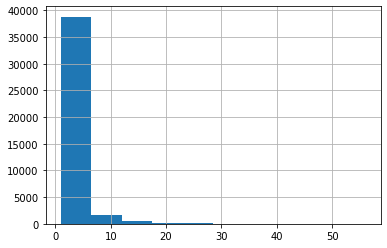

In [10]:
bank_data.campaign.hist()

print(bank_data.campaign.describe())

The largest value is 56 times. That seems like a huge number of contacts for one person. Does the distribution of this data make sense?

Intuitively, it seems like `campaign` should follow an exponential distribution. We can use a qq plot to verify this. A qq plot plots the actual distribution versus the best fit theoretical distribution (in this case, exponential):

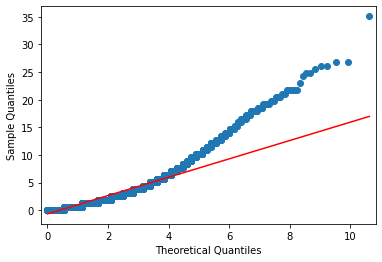

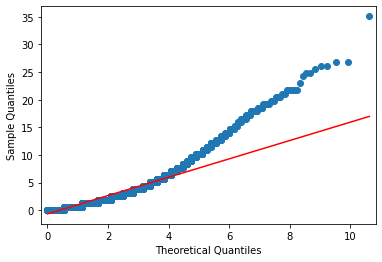

In [11]:
sm.qqplot(bank_data.campaign, fit=True, line='r', dist=stats.expon)

Ideally, we'd like to see a flat line there. So it doesn't (based on the eye test, at least) appear to be an exponential distribution, but it's close.

I found a better fit using the `gamma` distribution, which is just a more general version of the exponential with 2 parameters instead of one:

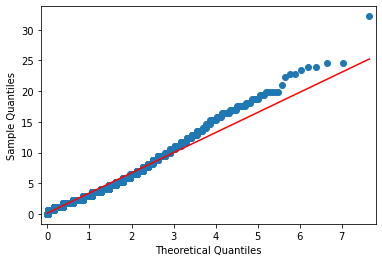

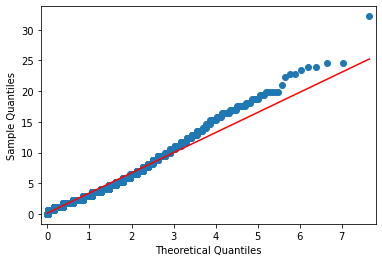

In [12]:
sm.qqplot(bank_data.campaign, fit=True, line='r',dist=stats.gamma)

This looks like a pretty good fit, so for now I'm going to assume that the data in the `campaign` field is organic, rather than being due to some type of error. However, the percentile values may end up being a better predictor than the raw values due to the long tail, so let's add that in:

In [13]:
bank_data['campaign_quartile'] = pd.qcut(bank_data['campaign'], 4, labels=False, duplicates='drop')

The remaining variables are all macroeconomic statistics (what their values were at time of contacting the customer): `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m` and `nr.employed`.

It's always interesting to look at which correlations are in the dataset. If we have 20 columns, are we really getting 20 dimensions worth of data, or are there some we could ignore because they are highly correlated with others? Let's check that for the economic factors.

In [14]:
macro_predictors = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                    'euribor3m', 'nr.employed']

bank_data.loc[:, macro_predictors].corr()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
emp.var.rate,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,0.906970,0.522034,0.100513,0.945154,1.000000


We can see `emp.var.rate`, `euribor3m` and `nr.employed` are very highly correlated. This is a bit surprising since `euribor3m` is the European inter-bank lending rate, `emp.var.rate` is the employment rate, and `nr.employed` is the number of employees. The strong correlation between lending rate and employment rate is curious, but may be explained by the time that this data came from (May 2008 to November 2010), which is in the aftermath of the global economic crisis at the end of 2008. [TODO: fix this sentence]

Since the correlations are so high, I may end up only using one of the 3 metrics in the final model in order to reduce the curse of dimensionality.

Let's start with a simple linear regression model to see how well we can do with the simplest possible model. We're going to need to normalize all the categorical data to be able to apply most learning algorithms. 

Most of these categorical variables don't have a natural order to them, so we will just encode them as dummy variables. For example, for the `education` field, instead of arbitrarily assigning integer values to `{single, married, divorced, unknown}`, we're adding variables like `{is_single, is_married, is_divorced, is_unknown}` that will be 1 or 0.

Note that for `month` and `day_of_week` it doesn't necessarily make sense to convert them to numbers. 'Tuesday' isn't monday +1 within the context of this model (there's no reason to believe that mon > tue > ... as far as conversion rate). so they're categorical variables even though they do have a 'meaningful' numerical equivalent.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#y = bank_data['y'].copy()
#x = bank_data.copy()
#
## we now need to convert all the categorical variables in x.
categorical_fields = ['job', 'marital', 'education', 'default', 'housing', 
                        'loan', 'contact', 'poutcome', 'month', 'day_of_week']

for field in categorical_fields:
    # I am dropping the most frequent category for each of these. I believe this will 
    # make the model's output more understandable. If not, I will use the built in pandas
    # feature to drop the first one instead.
    # dummies = pd.get_dummies(x[field], prefix=field, drop_first=True)
    #print(f"doing {field}")
    dummies = pd.get_dummies(bank_data[field], prefix=field)
    toss_cat_var_name = f"{field}_{bank_data[field].value_counts().idxmax()}"

    bank_data =   pd.concat([bank_data, dummies], axis='columns') \
              .drop([field, toss_cat_var_name], axis='columns')

## it doesn't make sense to convert day of week and month to numbers. 
# 'Tuesday' isn't monday +1 within the context of this model (there's no reason to believe
# that mon > tue > ... as far as conversion rate). so they're categorical variables even
# though they do have a 'meaningful' numerical equivalent.
bank_data['y'] = bank_data['y'].replace({'no': 0, 'yes': 1})

x = bank_data.copy().drop(['y'], axis=1)
y = bank_data['y'].copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)


A random forest classifier seems like a good first option, since it doesn't require normalization.

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_model.fit(x_train, y_train)

print(rf_model.score(x_train, y_train))


0.9946585735963581


The random forest classifier looks pretty good. 99.4% accurate. However, it's not significantly better than a dummy classifier on the test set.

In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dummy_model = DummyClassifier().fit(x_train, y_train)
dummy_pred = dummy_model.predict(x_test)

rf_pred = rf_model.predict(x_test)

print(f"Random Forest Model: {rf_model.score(x_test, y_test)}")
#print(classification_report(y_test, rf_pred))


print(f"Dummy Model: {dummy_model.score(x_test, y_test)}")
#print(classification_report(y_test, dummy_pred))



Random Forest Model: 0.8929351784413693
Dummy Model: 0.8865015780529255


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)


In [18]:
x.y

AttributeError: 'DataFrame' object has no attribute 'y'

In [18]:
## Let's try an SVM. Rather than use class_weight='balanced' 
# I will make sure the training set has equal amounts yes and no.

num_yes = count(x.y == )

x_train_yes = 


svc_model = SVC(class_weight='balanced').fit(x_train_scaled, y_train)

x_test_scaled = scaler.transform(x_test)

print(svc_model.score(x_test_scaled, y_test))

It's possible we can tune the hyperparameters to get a better result. Looking at the original paper, they looked at the AUC of the ROC curve. So let's see how our models perform.

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, rf_pred)

roc_auc = roc_auc_score(y_test, rf_pred)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="Random Forest(area = %0.2f)" % roc_auc,
)

### Plot dummy -- AUC should be .5
fpr, tpr, _ = roc_curve(y_test, dummy_pred)

roc_auc = roc_auc_score(y_test, dummy_pred)
plt.plot(
    fpr,
    tpr,
    color="green",
    lw=lw,
    label="Dummy (area = %0.2f)" % roc_auc,
)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()